<a href="https://colab.research.google.com/github/EmmaKLofthouse/SeedVision/blob/inception_model/seed_inception.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
from google.colab import drive
drive.mount("/content/drive/", force_remount=True)

Mounted at /content/drive/


# SeedVision: Neural Network Seed Classifier

# Load modules

In [27]:
!pip3 install split_folders
import splitfolders

In [28]:
# General
import numpy as np
import os
from glob import glob
import cv2

# TensorFlow
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.models import Sequential

# Metrics
from keras.metrics import Accuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Pre-trained Models
from tensorflow.keras.applications.inception_v3 import InceptionV3

#Plotting
import matplotlib.pyplot as plt

RANDOM_STATE = 42

In [29]:
# Set up GPU
config = ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

/usr/local/lib/python3.10/dist-packages/tensorflow/python/client/session.py:1793: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


## Save test sample

In [30]:
raw_dir = '/content/drive/MyDrive/Projects/SeedVision/raw_images'
output = "/content/drive/MyDrive/Projects/SeedVision"
splitfolders.ratio(raw_dir, output=output, seed=42, ratio=(0.9,0.1))

Copying files: 1156 files [04:58,  3.87 files/s]


## Train-validation split

In [31]:
raw_dir = '/content/drive/MyDrive/Projects/SeedVision/train'
output = "/content/drive/MyDrive/Projects/SeedVision/transfer"

splitfolders.ratio(raw_dir, output=output, seed=42, ratio=(0.7,0.3))

Copying files: 1037 files [00:21, 48.69 files/s]


# Load the pre-trained model

In [32]:
IMAGE_SIZE = [256,256]
inception = InceptionV3(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

In [33]:
# don't train existing weights
for layer in inception.layers:
   layer.trainable = False

# Create our model

In [34]:
train_dir = '/content/drive/MyDrive/Projects/SeedVision/transfer/train'
valid_dir = '/content/drive/MyDrive/Projects/SeedVision/transfer/val'

In [35]:
x = Flatten()(inception.output)

In [36]:
# Set output layer and add to model
categories = os.listdir(train_dir)
output_layer = Dense(len(categories), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=output_layer)

In [37]:
#model.summary()

In [38]:
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [39]:
# Set up samples and apply augmentation to training data
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range=30, fill_mode='nearest',
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   brightness_range=[0.6,1.3],
                                   horizontal_flip = True)

val_datagen = ImageDataGenerator(rescale = 1./255)

In [40]:
# Make sure you provide the same target size as initialied for the image size
train = train_datagen.flow_from_directory(train_dir,
                                                 target_size = IMAGE_SIZE,
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 718 images belonging to 14 classes.


In [41]:
val = val_datagen.flow_from_directory(valid_dir,
                                            target_size = IMAGE_SIZE,
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 319 images belonging to 14 classes.


# Train the model

In [42]:
# Set up tracking
log_dir = '/content/drive/MyDrive/Projects/SeedVision/logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [43]:
hist = model.fit(train,
                epochs=15,
                validation_data=val,
                callbacks=[tensorboard_callback])

Epoch 1/15
23/23 [==============================] - 40s 1s/step - loss: 21.0641 - accuracy: 0.2618 - val_loss: 11.9861 - val_accuracy: 0.4389
Epoch 2/15
23/23 [==============================] - 27s 1s/step - loss: 5.7726 - accuracy: 0.5891 - val_loss: 4.9925 - val_accuracy: 0.6332
Epoch 3/15
23/23 [==============================] - 29s 1s/step - loss: 2.5456 - accuracy: 0.7465 - val_loss: 5.1148 - val_accuracy: 0.6677
Epoch 4/15
23/23 [==============================] - 27s 1s/step - loss: 1.7364 - accuracy: 0.7911 - val_loss: 3.8414 - val_accuracy: 0.7179
Epoch 5/15
23/23 [==============================] - 27s 1s/step - loss: 1.2822 - accuracy: 0.8510 - val_loss: 3.1245 - val_accuracy: 0.7273
Epoch 6/15
23/23 [==============================] - 27s 1s/step - loss: 1.4115 - accuracy: 0.8412 - val_loss: 3.2467 - val_accuracy: 0.7179
Epoch 7/15
23/23 [==============================] - 26s 1s/step - loss: 1.1190 - accuracy: 0.8719 - val_loss: 4.3363 - val_accuracy: 0.7210
Epoch 8/15
23/23 [

# Evaluate Model Performance

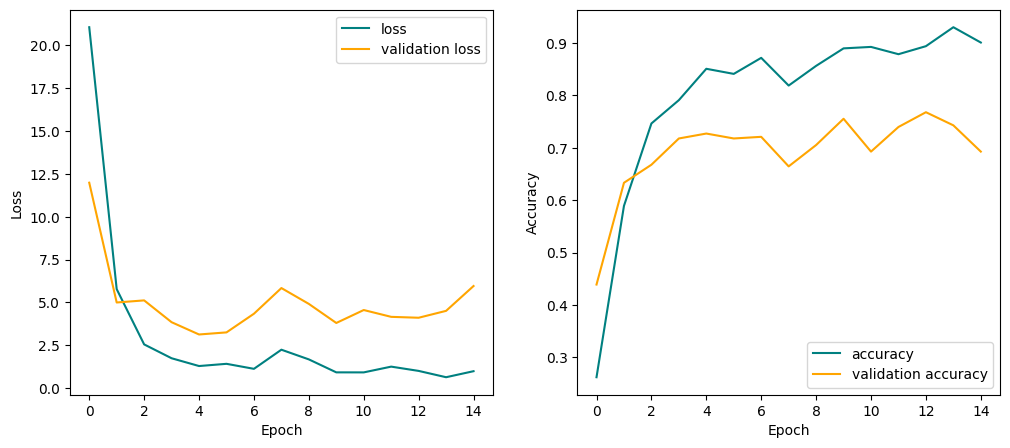

In [44]:
fig = plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(hist.history['loss'],color='teal',label='loss')
plt.plot(hist.history['val_loss'],color='orange',label='validation loss')
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.plot(hist.history['accuracy'],color='teal',label='accuracy')
plt.plot(hist.history['val_accuracy'],color='orange',label='validation accuracy')
plt.legend(loc='best')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")

plt.show()

# Test on unseen data

In [56]:
test_dir = '/content/drive/MyDrive/Projects/SeedVision/test'
test_datagen = ImageDataGenerator(rescale = 1./255)
test = test_datagen.flow_from_directory(test_dir,
                                        target_size = IMAGE_SIZE,
                                        batch_size = 32,
                                        class_mode = 'categorical')

Found 119 images belonging to 14 classes.


1/1 [==============================] - 0s 40ms/step


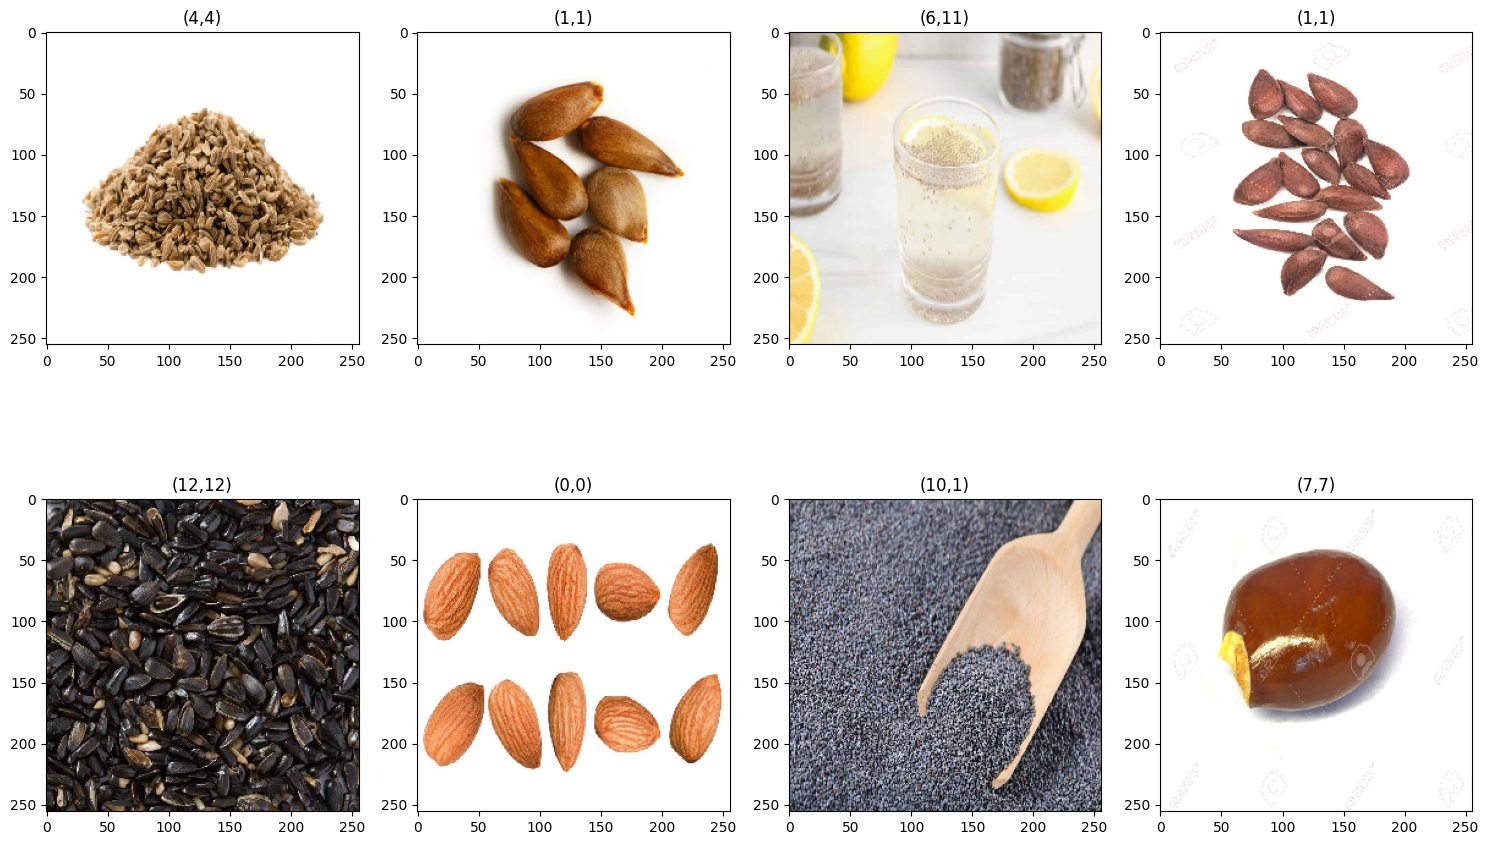

In [61]:
batch = test.next()
X, y = batch
preds = model.predict(X)

n_plots = 8
plt.figure(figsize=(15, 10))
for idx, img in enumerate(X[:n_plots]):
    plt.subplot(2, n_plots//2, idx+1)
    plt.imshow(img)
    predicted_class = np.argmax(preds[idx])
    plt.title(f"({np.argmax(y[idx])},{predicted_class})")

plt.tight_layout()
plt.show()

In [62]:
predicted_labels = []
true_labels = []

accuracy = Accuracy()

for idx,batch in enumerate(test):
    X, y = batch

    preds_prob = model.predict(X,verbose=False)
    predictions = [np.argmax(i) for i in preds_prob]

    true = [np.argmax(i) for i in y]
    accuracy.update_state(true, predictions)

    true_labels += list(true)
    predicted_labels += predictions

    # Stop the loop after iterating through all batches
    if idx >= len(test) - 1:
        break

print("Results for test data:")
print(f"Accuracy:  {accuracy.result().numpy():.2f}")

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:996: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Results for test data:
Accuracy:  0.66


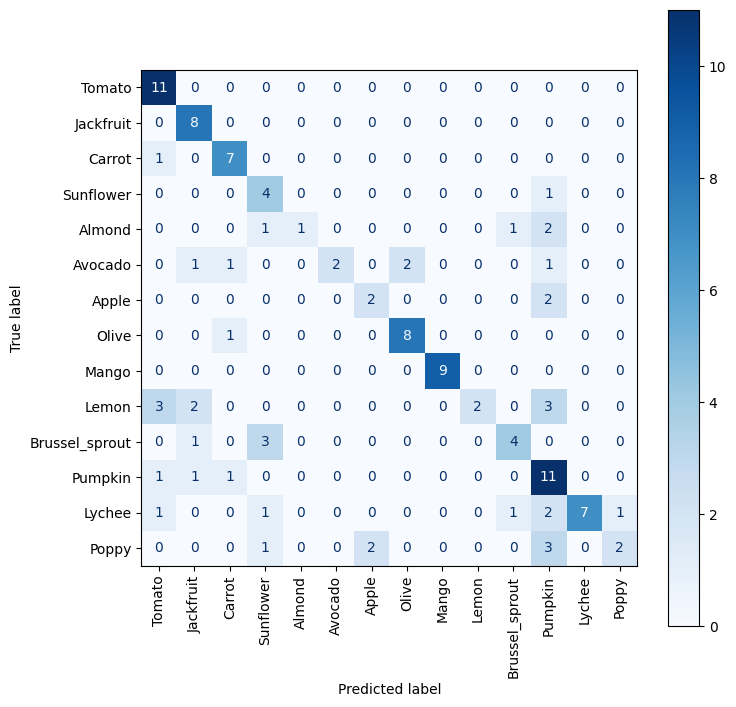

In [63]:
cm = confusion_matrix(true_labels, predicted_labels)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=categories)
fig, ax = plt.subplots(figsize=(8,8))
disp.plot(ax=ax, cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


# Save the model

In [64]:
model_name = 'model_inceptionV3'
model.save(os.path.join('/content/drive/MyDrive/Projects/SeedVision/models',model_name))

# Test on new image

In [24]:
model = load_model(os.path.join('/content/drive/MyDrive/Projects/SeedVision/models',model_name))

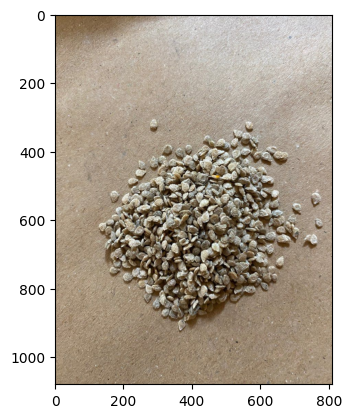

In [25]:
img_path = '/content/drive/MyDrive/Projects/SeedVision/test/Tomato/yellow_dwarf_cherry_tomato_see_1681716569_de988edc_progressive.jpg'
plt.imshow(image.load_img(img_path))
plt.show()

In [26]:
img = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
resize = tf.image.resize(img, IMAGE_SIZE)
predicted_probs = model.predict(np.expand_dims(resize/255, 0), verbose=False)
predicted_class = np.argmax(predicted_probs)
print(f"Predicted class is {categories[predicted_class]}")

Predicted class is Tomato
